# Using `enterprise` to analyze single pulsar noise

In this notebook you will learn:
* How to use `enterprise` to interact with PTA data,
* How to search in PTA data for GWs using a single pulsar,
* How to post-process your results.

# Load packages and modules

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

In [2]:
psrlist = None # define a list of pulsar name strings that can be used to filter.
# set the data directory
datadir = '../data'
if not os.path.isdir(datadir):
    datadir = '../../data'
print(datadir)

../../data


In [3]:
# get only J1909
psrname = 'J1909'
parfiles = sorted(glob.glob(datadir + '/par/' + psrname + '*par'))
timfiles = sorted(glob.glob(datadir + '/tim/' + psrname + '*tim'))

# filter
if psrlist is not None:
    parfiles = [x for x in parfiles if x.split('/')[-1].split('.')[0] in psrlist]
    timfiles = [x for x in timfiles if x.split('/')[-1].split('.')[0] in psrlist]

# Make sure you use the tempo2 parfile for J1713+0747!!
# ...filtering out the tempo parfile... 
parfiles = [x for x in parfiles if 'J1713+0747_NANOGrav_12yv3.gls.par' not in x]
print(parfiles)
print(timfiles)

['../../data/par/J1909-3744_NANOGrav_12yv3.gls.par']
['../../data/tim/J1909-3744_NANOGrav_12yv3.tim']


## Load into Pulsar class list
* The `enterprise` Pulsar class uses `libstempo` (or optionally `PINT`) to read in `par` and `tim` files, then stores all pulsar data into a `Pulsar` object. This object contains all data and meta-data needed for the ensuing pulsar and PTA analysis. You no longer to reference the `par` and `tim` files after this cell.
* Note below that you can explicitly declare which version of the JPL solar-system ephemeris model that will be used to compute the Roemer delay between the geocenter and the barycenter (e.g. `DE438`). Otherwise the default values will be taken from the `par` files. Explicitly declaring the version here is good practice.

In [4]:
psrs = []
ephemeris = 'DE438'
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem=ephemeris)
    psrs.append(psr)

* We can read-in some previously computed noise properties from single-pulsar white noise analyses. These are things like `EFAC`, `EQUAD`, and (for `NANOGrav`) `ECORR`. 
* In practice, we set these white-noise properties as fixed in the low-frequency noise / GW searches.
* See `singlepulsar_whitenoise_analysis.ipynb` to see the methods used to find these values.
* The noise properties have been stored as `json` files, and are read in to a big parameter dictionary.

In [5]:
## Get parameter noise dictionary
noise_ng12 = datadir + '/channelized_12p5yr_v3_full_noisedict.json'

params = {}
with open(noise_ng12, 'r') as fp:
    params.update(json.load(fp))

In [6]:
# find the maximum time span to set GW frequency sampling
tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

* In a full PTA analysis we fix all of the white noise (EFAC, EQUAD, and ECORR) parameters to the values obtained from the noise files. This is done by using `Constant` parameters. In this case we do not specify a default value for all instances of that parameter but instead will set them, based on their initialized pulsar and backend specific name later via the `set_default_params` method of `PTA`.

* For a single pulsar, it is not necessary to set the white noise as constant, but the computation time will increase with the increase in number of parameters. For this notebook, we set it as constant.

* We use the `Selection` object to define which noise parameters are assigned to which chunks of TOAs. This selection is based on unique combination of backends and receivers.

In [7]:
# define selection by observing backend
selection = selections.Selection(selections.by_backend)

### Parameters
* For this **detection** search, we will use a `Uniform` prior on the red noise, and set the white noise parameters as `Constant` with values added in later from the noise dictionary.

* In a single pulsar analysis, we can't look at spatial correlations. So we will exclude them here. They are mentioned in the full PTA analysis in the `pta_gwb_analysis.ipynb` notebook.

In [8]:
# white noise parameters
efac = parameter.Constant() 
equad = parameter.Constant() 
ecorr = parameter.Constant() # we'll set these later with the params dictionary

# red noise parameters
log10_A = parameter.Uniform(-20, -11)
gamma = parameter.Uniform(0, 7)

# dm-variation parameters
log10_A_dm = parameter.Uniform(-20, -11)
gamma_dm = parameter.Uniform(0, 7)

# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_A_gw = parameter.Uniform(-18,-12)('log10_A_gw')
gamma_gw = parameter.Constant(4.33)('gamma_gw')

### Signals

In [9]:
# white noise
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30, Tspan=Tspan)

# gwb (no spatial correlations)
cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
gw = gp_signals.FourierBasisGP(spectrum=cpl, components=30, Tspan=Tspan, name='gw')

# timing model
tm = gp_signals.TimingModel(use_svd=True)

In [10]:
# full model
s = ef + eq + ec + rn + tm + gw

In [11]:
# intialize PTA (this cell will take a minute or two to run)
models = []
        
for p in psrs:    
    models.append(s(p))
    
pta = signal_base.PTA(models)

In [13]:
# set white noise parameters with dictionary
pta.set_default_params(params)

In [14]:
# set initial parameters drawn from prior
x0 = np.hstack([p.sample() for p in pta.params])
ndim = len(x0)

In [16]:
# set up the sampler:
# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)
outDir = '../../chains/sngl_verbose'

sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, 
                 outDir=outDir, resume=True)

In [30]:
# sampler for N steps (this should take about 5 mins.)
N = int(1e6)
x0 = np.hstack([p.sample() for p in pta.params])
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

/Users/aaron/opt/anaconda3/envs/enterprise/lib/python3.7/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))
Finished 1.00 percent in 24.235714 s Acceptance rate = 0.5599Adding DE jump with weight 50
Finished 99.90 percent in 2136.305102 s Acceptance rate = 0.241632
Run Complete


In [32]:
chain = np.loadtxt(os.path.join(outDir, 'chain_1.txt'))
burn = int(0.25 * chain.shape[0])

In [33]:
ind = list(pta.param_names).index('log10_A_gw')

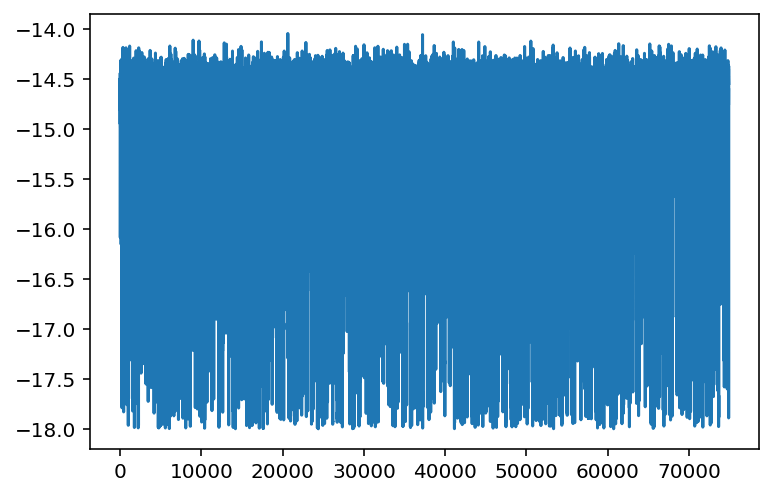

In [34]:
# Make trace-plot to diagnose sampling
plt.plot(chain[burn:, ind])

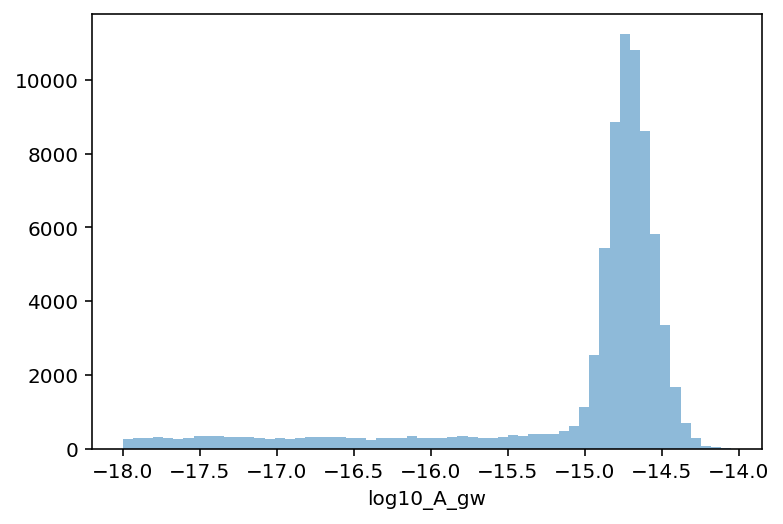

In [37]:
# Plot a histogram of the marginalized posterior distribution
plt.hist(chain[burn:,ind], 60, histtype='stepfilled', 
         lw=2, color='C0', alpha=0.5)
plt.xlabel('log10_A_gw')
plt.show()

In [36]:
hist = np.histogram(chain[burn:, pta.param_names.index('log10_A_gw')],
                          bins=60,
                          density=False)
max_ind = np.argmax(hist[0])
print('our_max =', hist[1][max_ind])  # from our computation

our_max = -14.77330780990182


## Discussion

* The posterior shows that there is likely a signal in the data. We can see this by examining the left side of the plot. There is still a tail that exists and extends out to the lower limit of our prior that has shown up in the posterior.
* `12p5yr_maxlike.json` shows `gw_log10_A` = -14.78361797461833 from the full 12.5 year analysis
* Our maximum is pretty close at `gw_log10_A` = -14.77330780990182
* This is from a single pulsar, J1909.

## Savage Dickey Approximation Bayes factor
* As long as the posterior has a tail, we can compare that tail with the prior to compute a quick Bayes factor
* To do this, we take a function from `enterprise_extensions` which will compare the prior and posterior

In [31]:
from enterprise_extensions.model_utils import bayes_fac

In [50]:
bf = bayes_fac(chain[burn:,ind], ntol = 200, logAmin = -18, logAmax = -12)
print(bf)

(3.092576316331859, 0.0717361316142241)


In [51]:
log10_bf = np.log10(bf[0])
print(log10_bf)

0.4903204256343364


## Remarks
* J1909 supports the common red noise in the data.